# Handwritten Chinese and Japanese OCR with OpenVINO™

In this tutorial, we perform optical character recognition (OCR) for handwritten Chinese (simplified) and Japanese. An OCR tutorial using the Latin alphabet is available in [notebook 208](../optical-character-recognition/optical-character-recognition.ipynb). This model is capable of processing only one line of symbols at a time.

The models used in this notebook are [`handwritten-japanese-recognition-0001`](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/handwritten-japanese-recognition-0001/README.md) and [`handwritten-simplified-chinese-0001`](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/handwritten-simplified-chinese-recognition-0001/README.md). To decode model outputs as readable text [`kondate_nakayosi`](https://github.com/openvinotoolkit/open_model_zoo/blob/master/data/dataset_classes/kondate_nakayosi.txt) and [`scut_ept`](https://github.com/openvinotoolkit/open_model_zoo/blob/master/data/dataset_classes/scut_ept.txt) charlists are used. Both models are available on [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/).


#### Table of contents:

- [Imports](#Imports)
- [Settings](#Settings)
- [Select a Language](#Select-a-Language)
- [Download the Model](#Download-the-Model)
- [Load the Model and Execute](#Load-the-Model-and-Execute)
- [Select inference device](#Select-inference-device)
- [Fetch Information About Input and Output Layers](#Fetch-Information-About-Input-and-Output-Layers)
- [Load an Image](#Load-an-Image)
- [Visualize Input Image](#Visualize-Input-Image)
- [Prepare Charlist](#Prepare-Charlist)
- [Run Inference](#Run-Inference)
- [Process the Output Data](#Process-the-Output-Data)
- [Print the Output](#Print-the-Output)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/handwritten-ocr/handwritten-ocr.ipynb" />


In [1]:
# Install openvino package
%pip install -q "openvino>=2023.1.0" opencv-python tqdm "matplotlib>=3.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 11.3 MB/s eta 0:00:00


## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from collections import namedtuple
from itertools import groupby
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, device_widget

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("handwritten-ocr.ipynb")

## Settings
[back to top ⬆️](#Table-of-contents:)

Set up all constants and folders used in this notebook

In [3]:
# Directories where data will be placed.
base_models_dir = Path("models")
data_folder = Path("data")
charlist_folder = Path(f"{data_folder}/text")

# Precision used by the model.
precision = "FP16"

To group files, you have to define the collection. In this case, use `namedtuple`.

In [4]:
Language = namedtuple(typename="Language", field_names=["model_name", "charlist_name", "demo_image_name"])
chinese_files = Language(
    model_name="handwritten-simplified-chinese-recognition-0001",
    charlist_name="chinese_charlist.txt",
    demo_image_name="handwritten_chinese_test.jpg",
)
japanese_files = Language(
    model_name="handwritten-japanese-recognition-0001",
    charlist_name="japanese_charlist.txt",
    demo_image_name="handwritten_japanese_test.png",
)

## Select a Language
[back to top ⬆️](#Table-of-contents:)

Depending on your choice you will need to change a line of code in the cell below.

If you want to perform OCR on a text in Japanese, set `language = "japanese"`. For Chinese, set `language = "chinese"`.

In [5]:
# Select the language by using either language="chinese" or language="japanese".
language = "chinese"

languages = {"chinese": chinese_files, "japanese": japanese_files}

selected_language = languages.get(language)

## Download the Model
[back to top ⬆️](#Table-of-contents:)

In addition to images and charlists, you need to download the model file. In the sections below, there are cells for downloading either the Chinese or Japanese model.

If it is your first time running the notebook, the model will be downloaded. It may take a few minutes.

Use `download_file` function from the utils package, which automatically creates a directory structure and downloads the selected model file.

In [6]:
path_to_model = base_models_dir / f"{selected_language.model_name}.xml"

if not path_to_model.exists():
    path_to_model = download_file(
        url=f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{selected_language.model_name}/{precision}/{selected_language.model_name}.xml",
        directory=base_models_dir,
    )
    download_file(
        url=f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{selected_language.model_name}/{precision}/{selected_language.model_name}.bin",
        directory=base_models_dir,
    )

handwritten-simplified-chinese-recognition-0001.xml:   0%|          | 0.00/108k [00:00<?, ?B/s]

handwritten-simplified-chinese-recognition-0001.bin:   0%|          | 0.00/32.9M [00:00<?, ?B/s]

## Load the Model and Execute
[back to top ⬆️](#Table-of-contents:)

When all files are downloaded and language is selected, read and compile the network to run inference. The path to the model is defined based on the selected language.

In [7]:
core = ov.Core()
model = core.read_model(model=path_to_model)

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
device = device_widget()
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [9]:
compiled_model = core.compile_model(model=model, device_name=device.value)

## Fetch Information About Input and Output Layers
[back to top ⬆️](#Table-of-contents:)

Now that the model is loaded, fetch information about the input and output layers (shape).

In [10]:
recognition_output_layer = compiled_model.output(0)
recognition_input_layer = compiled_model.input(0)

## Load an Image
[back to top ⬆️](#Table-of-contents:)

Next, load an image. The model expects a single-channel image as input, so the image is read in grayscale.

After loading the input image, get information to use for calculating the scale ratio between required input layer height and the current image height. In the cell below, the image will be resized and padded to keep letters proportional and meet input shape.

In [32]:
# Download the image from the openvino_notebooks storage based on the selected model.
file_name = data_folder / "Test_1.png"#selected_language.demo_image_name

# if not file_name.exists():
#     download_file(
#         "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/" + selected_language.demo_image_name,
#         directory=data_folder,
#     )

# Text detection models expect an image in grayscale format.
# IMPORTANT! This model enables reading only one line at time.

# Read the image.
image = cv2.imread(filename=str(file_name), flags=cv2.IMREAD_GRAYSCALE)

# Fetch the shape.
image_height, _ = image.shape

# B,C,H,W = batch size, number of channels, height, width.
_, _, H, W = recognition_input_layer.shape

# Calculate scale ratio between the input shape height and image height to resize the image.
scale_ratio = H / image_height

# Resize the image to expected input sizes.
resized_image = cv2.resize(image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA)

# Pad the image to match input size, without changing aspect ratio.
resized_image = np.pad(resized_image, ((0, 0), (0, W - resized_image.shape[1])), mode="edge")

# Reshape to network input shape.
input_image = resized_image[None, None, :, :]

## Visualize Input Image
[back to top ⬆️](#Table-of-contents:)

After preprocessing, you can display the image.

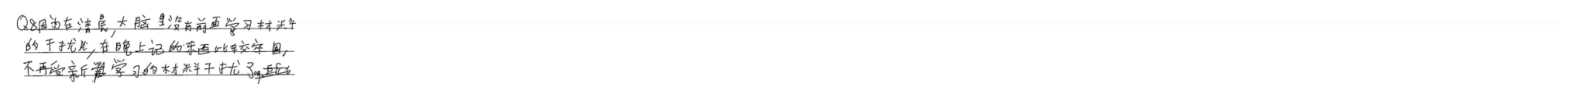

In [33]:
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255);

## Prepare Charlist
[back to top ⬆️](#Table-of-contents:)

The model is loaded and the image is ready. The only element left is the charlist, which is downloaded. You must add a blank symbol at the beginning of the charlist before using it. This is expected for both the Chinese and Japanese models.

In [26]:
# Download the image from the openvino_notebooks storage based on the selected model.
used_charlist_file = charlist_folder / selected_language.charlist_name

if not used_charlist_file.exists():
    used_charlist_file = download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/text/" + selected_language.charlist_name,
        directory=charlist_folder,
    )

In [27]:
# Get a dictionary to encode the output, based on model documentation.
used_charlist = selected_language.charlist_name

# With both models, there should be blank symbol added at index 0 of each charlist.
blank_char = "~"

with used_charlist_file.open(mode="r", encoding="utf-8") as charlist:
    letters = blank_char + "".join(line.strip() for line in charlist)

## Run Inference
[back to top ⬆️](#Table-of-contents:)

Now, run inference. The `compiled_model()` function takes a list with input(s) in the same order as model input(s). Then, fetch the output from output tensors.


In [28]:
# Run inference on the model
predictions = compiled_model([input_image])[recognition_output_layer]

## Process the Output Data
[back to top ⬆️](#Table-of-contents:)

The output of a model is in the `W x B x L` format, where:

* W - output sequence length
* B - batch size
* L - confidence distribution across the supported symbols in Kondate and Nakayosi.

To get a more human-readable format, select a symbol with the highest probability. When you hold a list of indexes that are predicted to have the highest probability, due to limitations in [CTC Decoding](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7), you will remove concurrent symbols and then remove the blanks.

Finally, get the symbols from corresponding indexes in the charlist.

In [29]:
# Remove a batch dimension.
predictions = np.squeeze(predictions)

# Run the `argmax` function to pick the symbols with the highest probability.
predictions_indexes = np.argmax(predictions, axis=1)

In [30]:
# Use the `groupby` function to remove concurrent letters, as required by CTC greedy decoding.
output_text_indexes = list(groupby(predictions_indexes))

# Remove grouper objects.
output_text_indexes, _ = np.transpose(output_text_indexes, (1, 0))

# Remove blank symbols.
output_text_indexes = output_text_indexes[output_text_indexes != 0]

# Assign letters to indexes from the output array.
output_text = [letters[letter_index] for letter_index in output_text_indexes]

## Print the Output
[back to top ⬆️](#Table-of-contents:)

Now, having a list of letters predicted by the model, you can display the image with predicted text printed below.

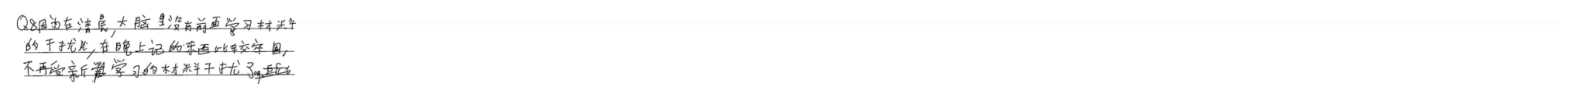

In [31]:
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255)

print("".join(output_text))